Plot u, v velocity on the horizontal plane

# Determine time period for an ebb tide given a day 

In [1]:
from __future__ import division

from cStringIO import StringIO
from salishsea_tools import (
    nc_tools,
    viz_tools,
    stormtools,
    tidetools,
)
from salishsea_tools.nowcast import figures
from matplotlib import pylab
from dateutil import tz
from matplotlib.backends import backend_agg as backend
from scipy import interpolate as interp
from matplotlib import animation
import scipy.io as sio
import datetime
import glob
import os
import arrow
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import netCDF4 as nc
import numpy as np
import pandas as pd
import requests

In [2]:
%matplotlib inline

In [3]:
SITES = {
    'Point Atkinson': {
        'lat': 49.33,
        'lon': -123.25,
        'msl': 3.09,
        'stn_no': 7795,
        'extreme_ssh': 5.61},
    'Victoria': {
        'lat': 48.41,
        'lon': -123.36,
        'msl': 1.8810,
        'stn_no': 7120,
        'extreme_ssh': 3.76},
    'Campbell River': {
        'lat': 50.04,
        'lon': -125.24,
        'msl': 2.916,
        'stn_no': 8074,
        'extreme_ssh': 5.35},
    'Neah Bay': {
        'lat': 48.4,
        'lon': -124.6,
        'stn_no':  9443090},
    'Friday Harbor': {
        'lat': 48.55,
        'lon': -123.016667,
        'stn_no': 9449880},
    'Cherry Point': {
        'lat': 48.866667,
        'lon': -122.766667,
        'stn_no': 9449424},
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30},
    'Tofino': {
        'stn_no': 8615},
    'VENUS': {
        'East': {
            'lat': 49.0419,
            'lon': -123.3176,
            'depth': 170},
        'Central': {
            'lat': 49.0401,
            'lon': -123.4261,
            'depth': 300}
        }
    }

In [4]:
def ebb_tide_time(grid_T, stn_name, PST , MSL = 0):
    "Determine ebb tide start time and end time in PST or UTC at\
    a given day at stations we got our tidal preditions"
    time_shift = datetime.timedelta(hours=-8)
    t_orig, t_end, t_nemo = figures.get_model_time_variables(grid_T)
    ttide = figures.get_tides(stn_name)
    time = ttide.time + PST * time_shift
    ssh = ttide.pred_all + SITES[stn_name]['msl'] * MSL
    for i in np.arange(len(ttide)):
        
        if (ttide.time[i].year == t_orig.year) & (ttide.time[i].month == t_orig.month)\
        & (ttide.time[i].day == t_orig.day):
            if (ssh[i] - ssh[i-1] >0) & (ssh[i] - ssh[i+1] >0):
                ebb_tide_start = ttide.time[i].hour
            
            if (ssh[i] - ssh[i-1] <0) & (ssh[i] - ssh[i+1] <0): 
                ebb_tide_end = ttide.time[i].hour
    if PST ==0:
        print "ebb tide begins at " + str(ebb_tide_start) +  ", ends at "\
        + str(ebb_tide_end) + " UTC time"
    else:
        print "ebb tide begins at " + str(ebb_tide_start) +  ", ends at "\
        + str(ebb_tide_end) + " PST time"
    return ebb_tide_start, ebb_tide_end  

In [5]:
def results_dataset(period, grid, results_dir):
    """Return the results dataset for period (e.g. 1h or 1d)
    and grid (e.g. grid_T, grid_U) from results_dir.
    """
    filename_pattern = 'SalishSea_{period}_*_{grid}.nc'
    filepaths = glob(os.path.join(results_dir, filename_pattern.format(period=period, grid=grid)))
    return nc.Dataset(filepaths[0])

In [6]:
run_date = datetime.datetime(2015,6,15)
# Results dataset location
results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [7]:
from glob import glob

In [8]:
grid_T = results_dataset('1h', 'grid_T', results_dir)

In [9]:
start, end = ebb_tide_time(grid_T, 'Point Atkinson', PST = 0, MSL = 0)

ebb tide begins at 11, ends at 19 UTC time


# plot only u, v quiver in the model coordinate system

In [10]:
## old U, V, T with old bathymetry
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
grid_U_hr = results_dataset('1h', 'grid_U', results_dir)
grid_V_hr = results_dataset('1h', 'grid_V', results_dir)

In [11]:
bathy = nc.Dataset('/data/dlatorne/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc') ##old bathymetry

In [12]:
## old ones for u,v
lat =grid_U_hr.variables['nav_lat'] ## for U grid
lon =grid_U_hr.variables['nav_lon']
zlevels = grid_U_hr.variables['depthu']
lats =grid_T_hr.variables['nav_lat'] ## for T grid
lons =grid_T_hr.variables['nav_lon']
timesteps = grid_U_hr.variables['time_counter']
u = grid_U_hr.variables['vozocrtx']
v = grid_V_hr.variables['vomecrty']

# Change the coordinate

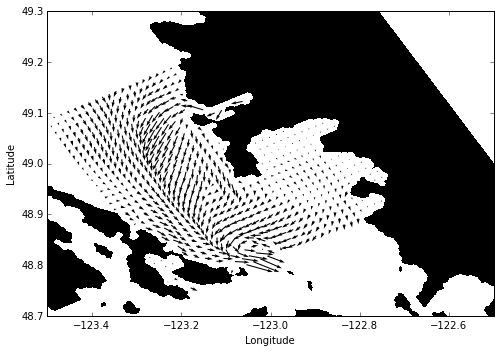

In [13]:
t, zlevel = 3, 0   ## original bathymetry
step = 3
y_slice = np.arange(350, 440)
x_slice = np.arange(260, 398)

lats_slice = lats[350 : 440, 260 : 398]
lons_slice = lons[350 : 440, 260 : 398]

theta=29
theta_rad=29 * np.pi / 180

u_masked = np.ma.masked_values(u[t, zlevel, y_slice, x_slice], 0)
v_masked = np.ma.masked_values(v[t, zlevel, y_slice, x_slice], 0)
u_masked, v_masked = viz_tools.unstagger(u_masked, v_masked)

u_E=u_masked * np.cos(theta_rad) - v_masked * np.sin(theta_rad)
v_N=u_masked * np.sin(theta_rad) + v_masked * np.cos(theta_rad)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
viz_tools.set_aspect(ax)

ax.quiver(lons_slice[1::3, 1::3], lats_slice[1::3, 1::3], u_E[::3,::3], v_N[::3,::3])
viz_tools.plot_land_mask(ax, bathy, coords='map', color='k')

ax.set_xlim([-123.5, -122.5])
ax.set_ylim([48.7, 49.3])
#ax.grid()

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# added with salinity contourf during ebb tide

In [14]:
start_time = datetime.datetime(2015,6,15, start)
end_time = datetime.datetime(2014,6,15, end)

numhours = (end_time - start_time).seconds // 3600
hours = [start_time + datetime.timedelta(hours=num)
             for num in range(0, numhours+1)]

In [15]:
ist=260
ien=398
jst=350
jen=440
depth=0
x=np.arange(ist,ien)
y=np.arange(jst,jen)
Us=np.zeros((1,y.shape[0],x.shape[0])); 

In [16]:
#subset
ist=260
ien=398
jst=350
jen=440
depth=0
x=np.arange(ist,ien)
y=np.arange(jst,jen)

#initalize arrays
Us=np.zeros((1, y.shape[0],x.shape[0])); 
Vs=np.zeros((1, y.shape[0],x.shape[0]))
Ss=np.zeros((1, y.shape[0],x.shape[0]))
time=np.array([])

#lats and lons
lat = bathy.variables['nav_lat'][jst:jen,ist:ien]
lon = bathy.variables['nav_lon'][jst:jen,ist:ien]

#loop through files

results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())
grid_U = results_dataset('1h','grid_U',results_dir)
grid_V = results_dataset('1h','grid_V',results_dir)
grid_T = results_dataset('1h','grid_T',results_dir)
    
#load variables
U = grid_U.variables['vozocrtx'][hours[0].hour: hours[len(hours) -1 ].hour + 1, 0,jst-1:jen,ist-1:ien]
V = grid_V.variables['vomecrty'][hours[0].hour: hours[len(hours) -1].hour + 1, 0,jst-1:jen,ist-1:ien]
S = grid_T.variables['vosaline'][hours[0].hour: hours[len(hours) -1].hour + 1, 0,jst:jen,ist:ien]

#masking
U = np.ma.masked_values(U,0)
V = np.ma.masked_values(V,0)

#unstagger
u,v = viz_tools.unstagger(U,V)
#rotate
theta = np.pi*29/180
uE = u*np.cos(theta) - v*np.sin(theta)
vN = u*np.sin(theta) +v*np.cos(theta)
#append
Us = np.append(Us,uE,axis=0)
Vs = np.append(Vs,vN,axis=0)
Ss = np.append(Ss,S,axis=0)

t = nc_tools.timestamp(grid_T, np.arange(len(hours)+ hours[0].hour))
for ind in range(len(t)):
    t[ind] = t[ind].datetime
time = np.append(time, t[hours[0].hour :]) 
##masking them
Us=Us[1:,:,:]; Us=np.ma.masked_values(Us,0)
Vs=Vs[1:,:,:]; Vs=np.ma.masked_values(Vs,0)
Ss=Ss[1:,:,:];

In [17]:
def quiver_salinity(t):
    ax.clear()
    #mesh
    mesh=ax.contourf(lon,lat,Ss[t],cs,cmap=cmap,extend='both')
    #land
    viz_tools.plot_land_mask(ax,bathy,coords='map',xslice=x,yslice=y,color='burlywood')
    #quivers
    quiver = ax.quiver(lon[::st,::st], lat[::st,::st], Us[t,::st,::st], Vs[t,::st,::st],
                       pivot='mid', width=0.003,scale=25, color='white',
                       headwidth=2,headlength=2)
    ax.quiverkey(quiver,-122.8,49.1, 1, '1 m/s',
                 coordinates='data', color='black', labelcolor='black')
    
    #title
    timestamp = time[t]
    ax.set_title(timestamp.strftime('%d-%b-%Y %H:%M'))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    return mesh

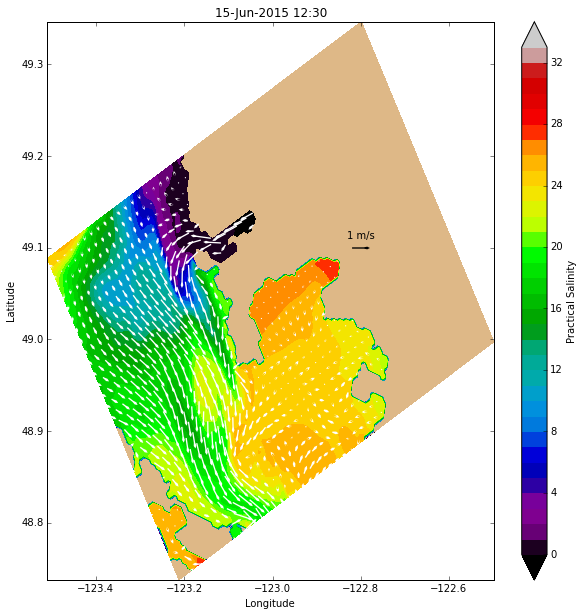

In [18]:
smin, smax, dels = 0, 34, 1
cs = np.arange(smin,smax)
cmap = plt.get_cmap('spectral')
st=3

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
t=1

mesh = quiver_salinity(t) ## plot quiver and salinity in different time
cbar = plt.colorbar(mesh, ax=ax)
cbar.set_label('Practical Salinity')

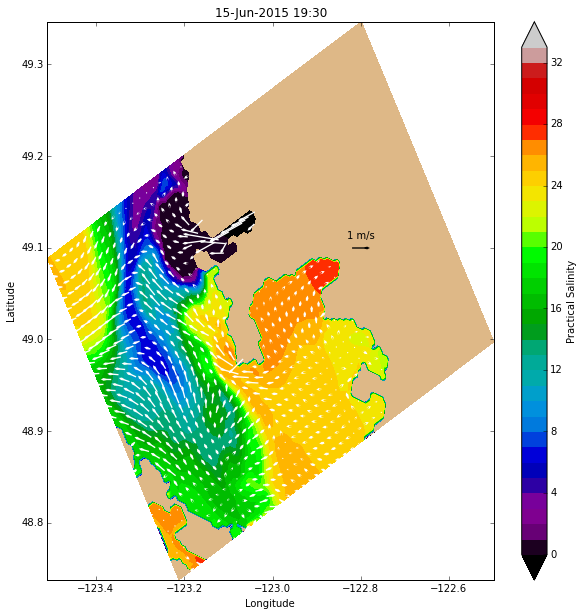

In [19]:
## make animation
#Setting up first frame and static content
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
mesh = quiver_salinity(0)
cbar = plt.colorbar(mesh, ax=ax)
cbar.set_label('Practical Salinity')

# list all frames
framess=np.arange(0,Us.shape[0])

#The animation function    
anim = animation.FuncAnimation(fig, quiver_salinity,frames=framess,  blit=True, repeat=False)

#A line that makes it all work
mywriter = animation.FFMpegWriter( fps=3, bitrate=10000)
anim.save('current_salinity-15jun15.mp4',writer=mywriter)